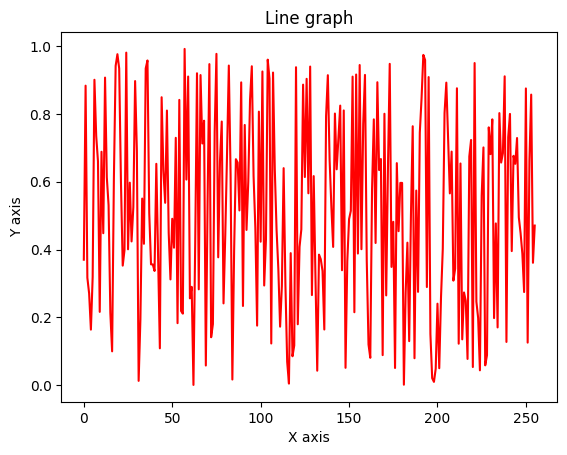

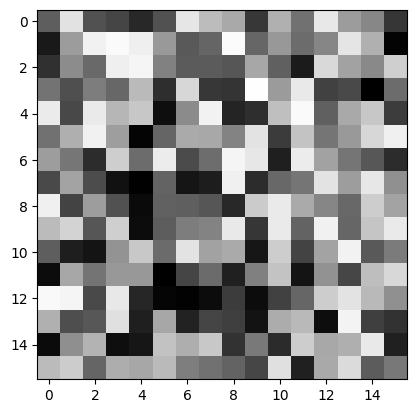

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import numpy as np
import math

mod = 4294967291
mul = 1588635695

def mlcg(seed, mul, mod):
    return seed * mul % mod

def random(seed, x):
    nums = np.array([])
    for i in range(x):
        seed = mlcg(seed, mul, mod)
        nums = np.append(nums, seed / mod)
    return nums

def plot(seed, x):
    nums = random(seed, x*x)
    plt.title("Line graph") 
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.plot( np.arange(x*x), nums, color ="red") 
    plt.show()
    nums = np.reshape(nums, (x,x))
    plt.imshow(nums, cmap = "gray", vmin = 0, vmax = 1)

plot(1, 16)

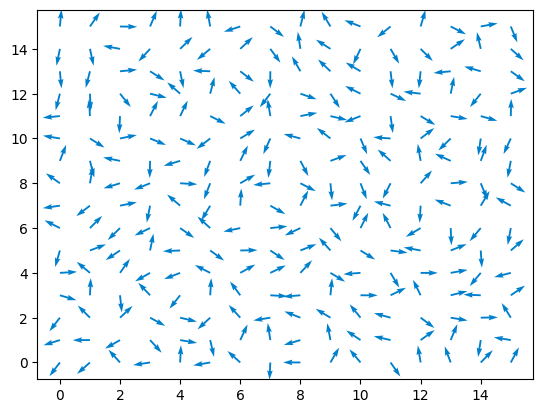

In [3]:
def generate_random_gradient(seed, q):
    noise = random(seed, q)
    xs = np.zeros(noise.size)
    ys = np.zeros(noise.size)
    for i, n in enumerate(noise):
        r = n * 2 * np.pi
        xs[i] = np.sin(r)
        ys[i] = np.cos(r)
    return xs, ys

def plot_gradient(seed,q):
    x,y = np.meshgrid(np.arange(0, q, 1), np.arange(0, q, 1))
    u,v = generate_random_gradient(seed, q*q)
    plt.quiver(x,y,u,v, color = [0,0.5,0.8])

plot_gradient(486489489, 16)

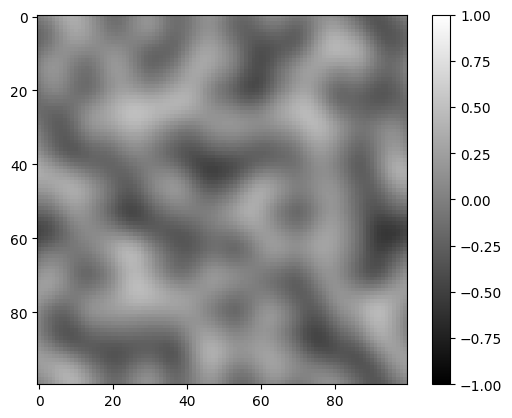

In [4]:
def pos_2d_1d(_x,_y,d):
    x = _x % d
    y = _y % d
    return (y*d+x)

def interpolate(a0,a1,w):
    return  (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w * w * w) + a0
    # return (a1 - a0) * w + a0;

def generate_perlin(seed, d, s):
    gx,gy = generate_random_gradient(seed, s*s)
    
    val = np.zeros(d*d)
    step = (s) / d
    for _y in range(d):
        for _x in range(d):
            x = _x*step
            y = _y*step
            # Revisit this whole crap
            x0 = math.floor(x)
            y0 = math.floor(y)
            x1 = (x0 + 1)
            y1 = (y0 + 1)
            sx = x - x0
            sy = y - y0
            
            pos = pos_2d_1d(x0,y0,s)
            n0 = np.dot([gx[pos],gy[pos]], [x0-x,y0-y])
            pos = pos_2d_1d(x1,y0,s)
            n1 = np.dot([gx[pos],gy[pos]], [x1-x,y0-y])
            i0 = interpolate(n0,n1,sx)
            
            pos = pos_2d_1d(x0,y1,s)
            n0 = np.dot([gx[pos],gy[pos]], [x0-x,y1-y])
            pos = pos_2d_1d(x1,y1,s)
            n1 = np.dot([gx[pos],gy[pos]], [x1-x,y1-y])
            i1 = interpolate(n0,n1,sx)

            st = pos_2d_1d(_x,_y,d)
            val[st] = interpolate(i0,i1,sy)
            # val[st] = interpolate(i0,i1,sy) * 0.5 + 0.5
    return val

def plot_perlin(seed, d, s):
    p_noise = generate_perlin(seed,d,s)
    p_noise = np.reshape(p_noise, (d,d))
    plt.imshow(p_noise, cmap = "gray", vmin = -1, vmax = 1)
    plt.colorbar()

plot_perlin(4864848, 100, 6)

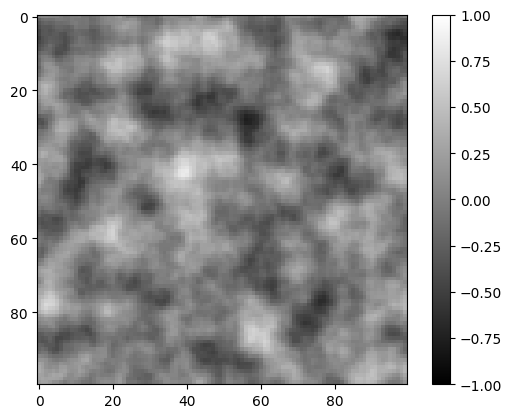

In [5]:
def fractal_brownian_motion(o,seed,d,s):
    amp = 1.0
    freq = s
    oct = np.zeros(d*d)
    for i in range(o):
        nums = generate_perlin(seed,d,freq)
        for j in np.arange(oct.size):
            oct[j] += nums[j]*amp
        amp *= 0.5
        freq *= 2
    return oct

def plot_fbm(o,seed,d,s):
    fbm = fractal_brownian_motion(o,seed,d,s)
    fbm = np.reshape(fbm, (d,d))
    plt.imshow(fbm, cmap = 'gray', vmin = -1, vmax = 1)
    plt.colorbar()

plot_fbm(4, 64523123, 100, 6)

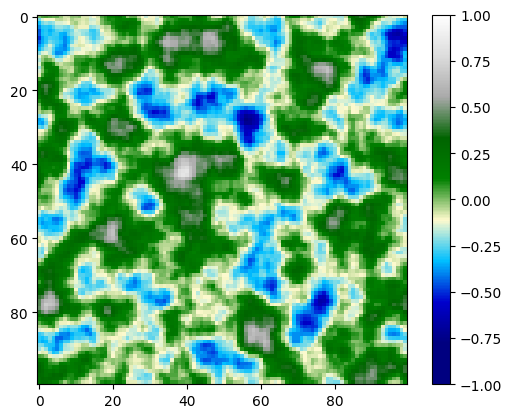

In [6]:
a_map = pltc.LinearSegmentedColormap.from_list("", ["Navy","Navy","MediumBlue","DeepSkyBlue","LemonChiffon","Green","DarkGreen","DarkGray","Gainsboro","White"])

def plot_fbm_c(o,seed,d,s):
    fbm = fractal_brownian_motion(o,seed,d,s)
    fbm = np.reshape(fbm, (d,d))
    plt.imshow(fbm, cmap = a_map, vmin = -1, vmax = 1)
    plt.colorbar()

plot_fbm_c(4, 64523123, 100, 6)

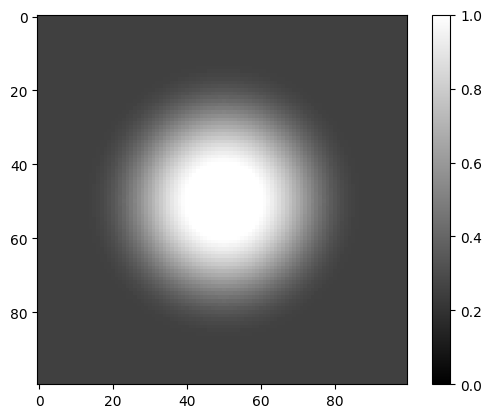

In [7]:
def generate_island_core_map(dim,cx,cy,spread):
    nums = np.zeros(dim*dim)
    for y in range(dim):
        for x in range(dim):
            # Get distance to centre point
            centre = np.array((cx,cy))
            current = np.array((x,y))
            dist = np.linalg.norm(centre - current)

            # num = -1
            num = -0.5
            # If within s then interpolate [x,y] + s = -1 and s = 1
            if dist < spread:
                w = dist / spread
                # num = interpolate(0.7,-1,w)
                num = interpolate(1.2,-0.5,w)
            # else set to -1
            # nums[y*dim+x] = num +1
            nums[y*dim+x] = (num +1)/2
    return nums

def plot_island_core(dim,cx,cy,spread):
    map = generate_island_core_map(dim,cx,cy,spread)
    map = np.reshape(map, (dim,dim))
    plt.imshow(map, cmap = "gray", vmin = 0, vmax = 1)
    plt.colorbar()

plot_island_core(100, 50, 50, 40)

10000


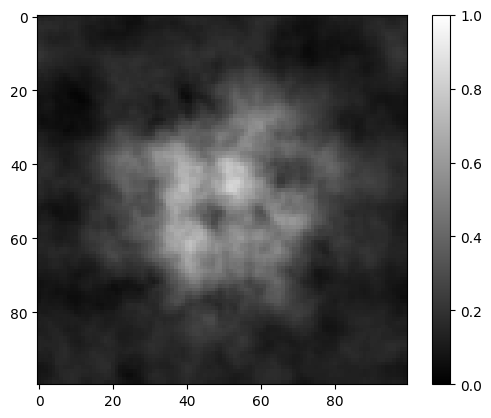

In [8]:
def generate_island(o,seed,d,s):
    c_amp = 0.55
    n_amp = 0.7

    c_xy = math.floor(d/2)
    m_core = generate_island_core_map(d, c_xy, c_xy, 50)
    m_noise = fractal_brownian_motion(o,seed,d,s)
    
    m_island = np.zeros(d*d)
    for i, _i in enumerate(m_island):
        c = m_core[i]
        n = m_noise[i]
        # m_island[i] = (c * c_amp) + (n * n_amp)
        m_island[i] = c * ((n+1)/2)

    return m_island

def plot_island(o,seed,d,s):
    isl = generate_island(o,seed,d,s)
    print(isl.size)
    isl = np.reshape(isl, (d,d))
    plt.imshow(isl, cmap = "gray", vmin = 0, vmax = 1)
    # plt.imshow(isl, cmap = a_map, vmin = -1, vmax = 1)
    plt.colorbar()

plot_island(4, 50, 100, 6)

10000


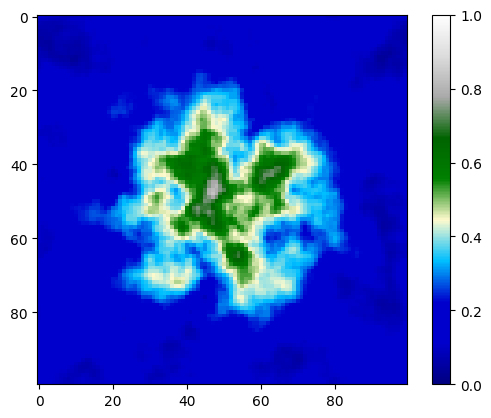

In [15]:
a_map = pltc.LinearSegmentedColormap.from_list("", ["Navy","MediumBlue","MediumBlue","DeepSkyBlue","LemonChiffon","Green","DarkGreen","Darkgrey","Gainsboro","White"])

def plot_island_c(o,seed,d,s):
    isl = generate_island(o,seed,d,s)
    print(isl.size)
    isl = np.reshape(isl, (d,d))
    plt.imshow(isl, cmap = a_map, vmin = 0, vmax = 1)
    plt.colorbar()

plot_island_c(4, 1998, 100, 6)